In [1]:
import pandas as pd
import os
from glob import glob
import json
import re
import numpy as np

In [2]:
# set working directory
#os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set whether to pull full tiles from external disk
#external_path = None
external_path = '/mnt/d/202109'

idx = 0
for d in glob('./cnn_results_downscaled_unetplus'):
    f_list = glob(d + '/best_model_*_validation.txt')
    f_list = [f for f in f_list if 'downscaled' in f or 'minscaled' in f]
    for f in f_list:
        with open(f, 'r') as src:
            val_dat = src.read()
            val_dat_list = []
            for i in val_dat.split("'"):
                if i == ': False, ':
                    val_dat_list.append(': false, ')
                elif i == ': True, ':
                    val_dat_list.append(': true, ')
                else:
                    val_dat_list.append(i)
            df_tmp = pd.DataFrame(json.loads(re.sub('nan', '"nan"', '"'.join(val_dat_list))), index=[idx])
            df_tmp['model'] = d.split('_')[-1]
            df_tmp['inputs'] = ','.join(os.path.basename(f).split('_')[2:-2])
            df_tmp['min_rp'] = df_tmp[['precision', 'recall']].min(axis=1)
            if 'downscaled' in os.path.basename(f):
                df_tmp['scaling'] = '_downscaled'
            elif 'minscaled' in os.path.basename(f):
                df_tmp['scaling'] = '_minscaled'
            else:
                df_tmp['scaling'] = ''
            df_tmp['model_path'] = re.sub('_validation.txt', '.pth', f)
            if idx == 0:
                df_val = df_tmp
            else:
                df_val = pd.concat([df_val, df_tmp])
            idx += 1

In [3]:
for d in glob('./cnn_results_*'):
    f_list = glob(d + '/best_model_*_validation.txt')
    f_list = [f for f in f_list if not 'downscaled' in f and not 'minscaled' in f]
    for f in f_list:
        with open(f, 'r') as src:
            val_dat = src.read()
            val_dat_list = []
            for i in val_dat.split("'"):
                if i == ': False, ':
                    val_dat_list.append(': false, ')
                elif i == ': True, ':
                    val_dat_list.append(': true, ')
                else:
                    val_dat_list.append(i)
            df_tmp = pd.DataFrame(json.loads(re.sub('nan', '"nan"', '"'.join(val_dat_list))), index=[idx])
            df_tmp['model'] = d.split('_')[-1]
            df_tmp['inputs'] = ','.join(os.path.basename(f).split('_')[2:-1])
            df_tmp['min_rp'] = df_tmp[['precision', 'recall']].min(axis=1)
            df_tmp['scaling'] = ''
            df_tmp['model_path'] = re.sub('_validation.txt', '.pth', f)
            if df_tmp['model'][idx] == df_val['model'].unique() and df_tmp['inputs'][idx] in df_val['inputs'].unique():
                df_val = pd.concat([df_val, df_tmp])
            idx += 1

In [4]:
# recompute fscore-beta manually
df_val['fscore_old'] = df_val['fscore']
beta = 1.0
df_val['fscore'] = df_val.apply(lambda x: ((1 + beta) * x['recall'] * x['precision']) / (x['recall'] + beta * x['precision']), axis=1)

In [5]:
df_val.sort_values('fscore', ascending=False).head(20)

,mccloss,iou_score,accuracy,precision,recall,fscore,best_epoch,downscaled,newsize,origsize,resolution,model,inputs,min_rp,scaling,model_path,fscore_old
250,0.743204,0.877344,0.994782,0.923132,0.944633,0.933759,31,NaN,NaN,NaN,1.5,unetplus,"rgb,tpi,shade,ndvi",0.923132,,./cnn_results_unetplus/best_model_rgb_tpi_shad...,0.915198
34,0.770214,0.853852,0.994620,0.927619,0.915126,0.921330,30,False,96x96px,384x384px,6.0,unetplus,"rgb,tpi,shade,dsm",0.915126,,./cnn_results_downscaled_unetplus/best_model_r...,0.892080
22,0.777218,0.850614,0.994166,0.909300,0.932554,0.920780,21,False,192x192px,384x384px,3.0,unetplus,"rgb,tpi,ndvi",0.909300,,./cnn_results_downscaled_unetplus/best_model_r...,0.889229
41,0.775280,0.853302,0.994747,0.930867,0.909468,0.920043,26,False,96x96px,384x384px,6.0,unetplus,"rgb,tpi,shade,ndvi",0.909468,,./cnn_results_downscaled_unetplus/best_model_r...,0.890404
39,0.789796,0.843737,0.994095,0.938376,0.897724,0.917600,17,False,192x192px,384x384px,3.0,unetplus,"rgb,tpi,shade,ndvi",0.897724,,./cnn_results_downscaled_unetplus/best_model_r...,0.877409
32,0.776281,0.841605,0.994518,0.908792,0.926499,0.917560,22,False,192x192px,384x384px,3.0,unetplus,"rgb,tpi,shade,dsm",0.908792,,./cnn_results_downscaled_unetplus/best_model_r...,0.876792
25,0.803817,0.841977,0.993824,0.929858,0.903193,0.916331,11,False,192x192px,384x384px,3.0,unetplus,"rgb,tpi",0.903193,,./cnn_results_downscaled_unetplus/best_model_r...,0.877149
24,0.780391,0.839159,0.994274,0.920400,0.911346,0.915851,25,False,96x96px,384x384px,6.0,unetplus,"rgb,tpi,ndvi",0.911346,,./cnn_results_downscaled_unetplus/best_model_r...,0.875537
247,0.791870,0.845436,0.994034,0.911320,0.918794,0.915042,24,NaN,NaN,NaN,1.5,unetplus,"rgb,tpi,ndvi",0.911320,,./cnn_results_unetplus/best_model_rgb_tpi_ndvi...,0.884013
252,0.798068,0.839452,0.993275,0.910587,0.913654,0.912118,13,NaN,NaN,NaN,1.5,unetplus,"rgb,tpi",0.910587,,./cnn_results_unetplus/best_model_rgb_tpi.pth,0.877932


### Plot validation results

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='resolution', ylabel='fscore'>

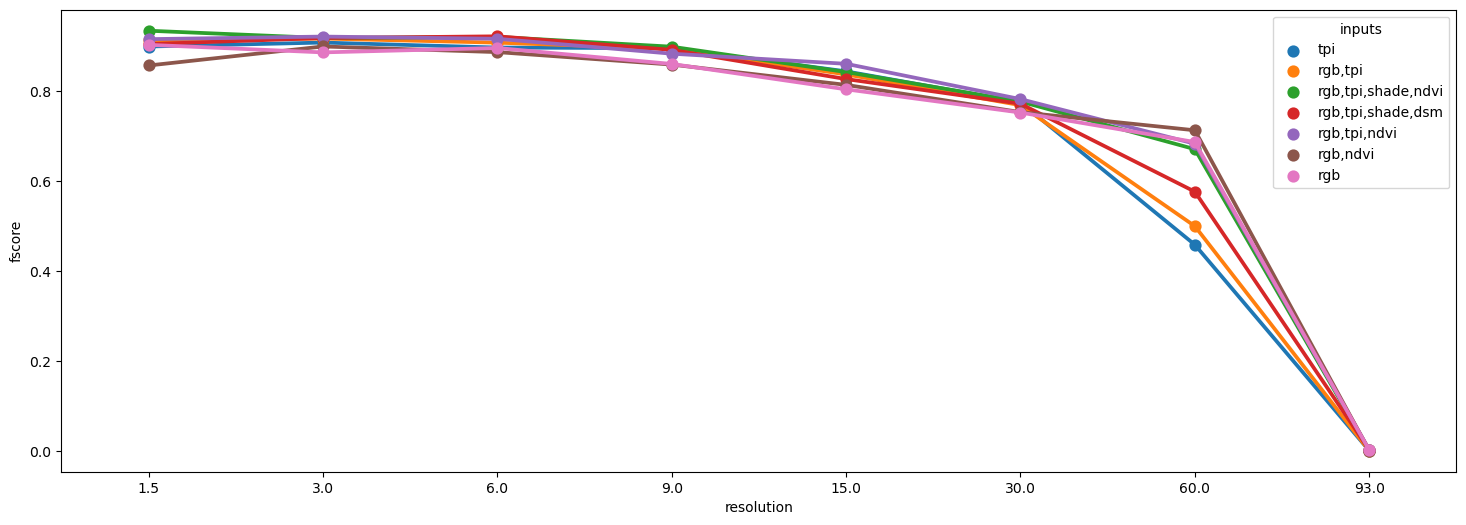

In [7]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.pointplot(x='resolution', y='fscore', 
            hue='inputs',
            data=df_val.sort_values('resolution'),
            ci=None,
            ax=ax)

## Test best model

### Set parameters and datasets

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [9]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [10]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'# 'cpu'# 

### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [11]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dsm': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'},
        'ndvi': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_s[np.isnan(image_s)] = 0
            if s == 'ndvi':
                image_s[image_s < 0] = 0
            if self.preprocessing:
                image_s = normalize_fn(image_s, s, image_stats)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='float32')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # convert final image arrays to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1).astype('float32'))
        mask = torch.from_numpy(mask.transpose(2, 0, 1).astype('float32'))
        return image, mask
        
    def __len__(self):
        return len(self.ids)




In [12]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)
    
        

### Quantify and Visualize Test Data Predictions

In [13]:
import itertools
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
import shapely.wkt as wkt
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torch.nn as nn
from skimage.transform import resize

In [14]:
# helper function for data visualization
def visualize(show=True, write=False, path=None, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if show:
        plt.show()
    if write:
        plt.savefig(path)
    if not show and write:
        plt.close()

In [15]:
df_polys['geometry'] = df_polys.geometry.apply(lambda x: Polygon(wkt.loads(x)))
gdf_polys = gpd.GeoDataFrame(df_polys, geometry='geometry')
gdf_polys = gdf_polys.set_crs(32613)

In [17]:
if os.path.exists('./cnn_test_results/downscaled_model_test_validation.csv'):
    df_test_out = pd.read_csv('./cnn_test_results/downscaled_model_test_validation.csv')
else:
    df_test_out = pd.DataFrame(columns=['model', 'scaling', 'model_resolution', 'inputs',
                                        'test_resolution', 'precision', 'recall', 'fscore', 'correlation'])

In [18]:
df_test_out

,Unnamed: 0,model,scaling,model_resolution,inputs,test_resolution,precision,recall,fscore,correlation
0,0,unetplus,downscaled,15.0,rgb,15.0,0.491525,0.417391,0.451435,0.171197
1,1,unetplus,downscaled,60.0,rgb,60.0,0.134228,0.108491,0.119995,0.188909
2,2,unetplus,downscaled,30.0,rgb,30.0,0.320755,0.162996,0.216151,0.246562
3,3,unetplus,minscaled,93.0,rgb,93.0,0.000921,0.458333,0.001838,-0.147572
4,4,unetplus,downscaled,15.0,"rgb,ndvi",15.0,0.710526,0.413043,0.522403,0.676068
5,5,unetplus,downscaled,60.0,"rgb,ndvi",60.0,0.168103,0.268868,0.206868,0.617093
6,6,unetplus,downscaled,30.0,"rgb,ndvi",30.0,0.424242,0.242291,0.308432,0.629926
7,7,unetplus,minscaled,93.0,"rgb,ndvi",93.0,0.000000,0.833333,0.000000,-0.170908
8,8,unetplus,NaN,3.0,"rgb,ndvi",3.0,0.730769,0.649351,0.687658,0.861604
9,9,unetplus,NaN,9.0,"rgb,ndvi",9.0,0.357827,0.539130,0.430155,0.268964


In [20]:
preprocess = True
for idx, row in df_val.iterrows():
    print(row[['scaling', 'resolution', 'inputs']])
    res = row['resolution']
    scaling = row['scaling']
    inputs_fnl = row['inputs'].split(',')
    if len(df_test_out[(df_test_out['model_resolution'] == row['resolution']) &
                       (df_test_out['inputs'] ==row['inputs']) &
                       (df_test_out['test_resolution'] == res)]) > 0:
        print('Skipping. Model already validated.')
        continue
    else:
        # load best saved checkpoint
        best_model = torch.load(row['model_path'])
        best_model.eval()

        newsize = int(round((3000 / res) / 32, 0)) * 32
        if newsize > 256:
            newsize = int((3000 / res) / 256) * 256

        # load the image stats from the training data
        df_image_stats = pd.read_csv('./_utils/image_stats' + scaling + '.csv').set_index('stat')

        # convert image stats dictionary to dataframe
        image_stats = {i: {'min': df_image_stats.loc['min', i],
                           'max': df_image_stats.loc['max', i]} for i in [x for x in inputs_fnl if x != 'dsm']}

        precision_list = []
        recall_list = []

        burrow_ct_gt = []
        burrow_ct_pred = []
        tile_id_list = []

        for ID in df_tiles['ID'][(df_tiles['Train'] == 0) &
                                 (df_tiles['Digitize'] == 1) &
                                 (df_tiles['trainer'] != 'Nick')]:
            if all(df_tiles[df_tiles['ID'] == ID]['Train'] == 1):
                continue
            else:
                print(ID)
                # get the path base to the imagery associated with the training tile
                if external_path is None:
                    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
                else:
                    tilePATH = os.path.join(external_path,
                                            df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0])
                # get the x/y coordinates of the bounding box for the training polygon within the tile
                box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
                box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
                # get the box coordinate pairs
                ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
                # create a polygon from the coordinate pairs
                tile_geom = Polygon([ll, ul, ur, lr])
                # create the full path to the RGB image of the training tile
                rgb_path = tilePATH + 'rgb.tif'
                with rio.open(rgb_path) as src_rgb:   
                    profile_rgb = src_rgb.meta
                    rgb_out, transform_out = mask.mask(src_rgb,
                                                       [tile_geom],
                                                       crop=True)
                    #rgb_out = rgb_out[:, -win_size:, :win_size]
                    #show(rgb_out)
                    ll_i = src_rgb.index(*ll)
                    ur_i = src_rgb.index(*ur)
                    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
                    if len(gdf_polys_sub) > 0:
                        label_mask = rasterize(gdf_polys_sub.geometry, 
                                               out_shape=rgb_out.shape[1:], 
                                               transform=transform_out,
                                               default_value=1)
                    else:
                         label_mask = np.zeros_like(rgb_out[0, :, :]) 
                    rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                                     (newsize, newsize),
                                     order=1).transpose((2, 0, 1)).astype('int')
                    label_mask = resize(label_mask.astype('float32'), (newsize, newsize), anti_aliasing=True, order=1) > 0.5
                    label_mask = label_mask.astype('int')
                    #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
                    profile_rgb.update({'dtype': 'int16',
                                        'width': rgb_out.shape[1],
                                        'height': rgb_out.shape[0],
                                        'transform': transform_out})
                    profile_single = profile_rgb.copy()
                    profile_single.update({'count': 1})
                    profile_single_float = profile_single.copy()
                    profile_single_float.update({'dtype': 'float64'})
                    #show(label)

                pr_mask = np.empty_like(rgb_out[0, :, :])
                image_dict = {}
                for suffix in inputs_fnl:
                    with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
                        i_out = src_i.read(out_shape=(
                            src_i.count,
                            src_rgb.meta['height'],
                            src_rgb.meta['width']),
                                           resampling=Resampling.bilinear)
                        image_dict[suffix] = resize(i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1].transpose((1, 2, 0)),
                                                    (newsize, newsize),
                                                    order=1).transpose((2, 0, 1))
                if 'rgb' in inputs_fnl:
                    image_dict['rgb'] = rgb_out
                if preprocess:
                    for i in image_dict:
                        image_dict[i] = normalize_fn(image_dict[i], i, image_stats)
                image_list = [image_dict[i].astype('float32') for i in inputs_fnl]
                image_out = np.concatenate(image_list, axis=0)

                chunksize = 256
                if newsize > 256:
                    pr_mask = np.empty_like(rgb_out[0, :, :])
                    n_row_chunks = int(np.ceil(rgb_out.shape[1]/chunksize))
                    n_col_chunks = int(np.ceil(rgb_out.shape[2]/chunksize))
                    image_sub_dict = {}
                    for r in range(n_row_chunks):
                        if (r + 1) * chunksize > rgb_out.shape[1]:
                            r_min = rgb_out.shape[1] - chunksize
                            r_max = rgb_out.shape[1]
                        else:
                            r_min = r * chunksize
                            r_max = (r + 1) * chunksize
                        for c in range(n_col_chunks):
                            if (c + 1) * chunksize > rgb_out.shape[2]:
                                c_min = rgb_out.shape[2] - chunksize
                                c_max = rgb_out.shape[2]
                            else:
                                c_min = c * chunksize
                                c_max = (c + 1) * chunksize
                            image_out_sub = image_out[:, r_min:r_max, c_min:c_max]
                            x_tensor = torch.from_numpy(image_out_sub).to(DEVICE).unsqueeze(0)
                            if type(best_model) == nn.DataParallel:
                                pr_mask[r_min:r_max, c_min:c_max] = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                            else:
                                pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                else:
                    x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                    if type(best_model) == nn.DataParallel:
                        pr_mask = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                    else:
                        pr_mask = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5

                # get regions and properties of the ground truth and predictions
                label_labels = label(label_mask)
                label_regions = regionprops(label_labels)
                pr_labels = label(pr_mask)
                pr_regions = regionprops(pr_labels)

                r_ct_pred = 0
                for r in pr_regions:
                    if r.area*(res/100)**2 > 0.05:
                        y_pr, x_pr = r.centroid
                        precision_list.append(label_mask[int(y_pr), int(x_pr)])
                        r_ct_pred += 1

                r_ct_gt = 0
                for r in label_regions:
                    y_label, x_label = r.centroid
                    recall_list.append(pr_mask[int(y_label), int(x_label)])
                    r_ct_gt += 1
                burrow_ct_gt.append(r_ct_gt)
                burrow_ct_pred.append(r_ct_pred)
                tile_id_list.append(ID)

        precision = np.sum(precision_list) / len(precision_list)
        recall = np.sum(recall_list) / len(recall_list)
        fscore = (2 * precision * recall) / (precision + recall)
        corr = np.corrcoef(burrow_ct_gt, burrow_ct_pred)[0, 1]

        df_tmp = pd.DataFrame({
            'model': row['model'],
            'scaling': re.sub('_', '', scaling),
            'model_resolution': row['resolution'],
            'inputs': row['inputs'],
            'test_resolution': res,
            'precision': precision,
            'recall': recall,
            'fscore': fscore,
            'correlation': corr
        }, index=[idx])

        df_test_out = pd.concat([df_test_out, df_tmp])
        df_test_out.to_csv('./cnn_test_results/downscaled_model_test_validation.csv')

scaling       _downscaled
resolution           15.0
inputs                rgb
Name: 0, dtype: object
Skipping. Model already validated.
scaling       _downscaled
resolution           60.0
inputs                rgb
Name: 1, dtype: object
Skipping. Model already validated.
scaling       _downscaled
resolution           30.0
inputs                rgb
Name: 2, dtype: object
Skipping. Model already validated.
scaling       _minscaled
resolution          93.0
inputs               rgb
Name: 3, dtype: object
Skipping. Model already validated.
scaling       _downscaled
resolution           15.0
inputs           rgb,ndvi
Name: 4, dtype: object
Skipping. Model already validated.
scaling       _downscaled
resolution           60.0
inputs           rgb,ndvi
Name: 5, dtype: object
Skipping. Model already validated.
scaling       _downscaled
resolution           30.0
inputs           rgb,ndvi
Name: 6, dtype: object
Skipping. Model already validated.
scaling       _minscaled
resolution          93.0
i

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling       _downscaled
resolution           60.0
inputs            rgb,tpi
Name: 15, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling       _downscaled
resolution           30.0
inputs            rgb,tpi
Name: 16, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling       _minscaled
resolution          93.0
inputs           rgb,tpi
Name: 17, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling        _downscaled
resolution            15.0
inputs        rgb,tpi,ndvi
Name: 18, dtype: object
5W_9


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling        _downscaled
resolution            60.0
inputs        rgb,tpi,ndvi
Name: 19, dtype: object
5W_9


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling        _downscaled
resolution            30.0
inputs        rgb,tpi,ndvi
Name: 20, dtype: object
5W_9


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling         _minscaled
resolution            93.0
inputs        rgb,tpi,ndvi
Name: 21, dtype: object
5W_9


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling                   
resolution             3.0
inputs        rgb,tpi,ndvi
Name: 22, dtype: object
5W_9


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling                   
resolution             9.0
inputs        rgb,tpi,ndvi
Name: 23, dtype: object
5W_9


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling                   
resolution             6.0
inputs        rgb,tpi,ndvi
Name: 24, dtype: object
5W_9


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling              
resolution        3.0
inputs        rgb,tpi
Name: 25, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling              
resolution        9.0
inputs        rgb,tpi
Name: 26, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling              
resolution        6.0
inputs        rgb,tpi
Name: 27, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling             _downscaled
resolution                 15.0
inputs        rgb,tpi,shade,dsm
Name: 28, dtype: object
Skipping. Model already validated.
scaling             _downscaled
resolution                 60.0
inputs        rgb,tpi,shade,dsm
Name: 29, dtype: object
Skipping. Model already validated.
scaling             _downscaled
resolution                 30.0
inputs        rgb,tpi,shade,dsm
Name: 30, dtype: object
Skipping. Model already validated.
scaling              _minscaled
resolution                 93.0
inputs        rgb,tpi,shade,dsm
Name: 31, dtype: object
Skipping. Model already validated.
scaling                        
resolution                  3.0
inputs        rgb,tpi,shade,dsm
Name: 32, dtype: object
Skipping. Model already validated.
scaling                        
resolution                  9.0
inputs        rgb,tpi,shade,dsm
Name: 33, dtype: objec

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling       _downscaled
resolution           60.0
inputs                tpi
Name: 43, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling       _downscaled
resolution           30.0
inputs                tpi
Name: 44, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling       _minscaled
resolution          93.0
inputs               tpi
Name: 45, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling          
resolution    3.0
inputs        tpi
Name: 46, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling          
resolution    9.0
inputs        tpi
Name: 47, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling          
resolution    6.0
inputs        tpi
Name: 48, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling               
resolution         1.5
inputs        rgb,ndvi
Name: 240, dtype: object
Skipping. Model already validated.
scaling                   
resolution             1.5
inputs        rgb,tpi,ndvi
Name: 247, dtype: object
5W_9


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling                        
resolution                  1.5
inputs        rgb,tpi,shade,dsm
Name: 248, dtype: object
Skipping. Model already validated.
scaling                         
resolution                   1.5
inputs        rgb,tpi,shade,ndvi
Name: 250, dtype: object
Skipping. Model already validated.
scaling              
resolution        1.5
inputs        rgb,tpi
Name: 252, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling          
resolution    1.5
inputs        rgb
Name: 253, dtype: object
Skipping. Model already validated.
scaling          
resolution    1.5
inputs        tpi
Name: 265, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16


In [28]:
df_test_out = pd.DataFrame(columns=['model', 'scaling', 'model_resolution', 'inputs',
                                    'test_resolution', 'precision', 'recall', 'fscore', 'correlation'])

In [29]:
preprocess = True
for res in df_val['resolution'].sort_values().unique():
    print(res)
    newsize = int(round((3000 / res) / 32, 0)) * 32
    if newsize > 256:
        newsize = int((3000 / res) / 256) * 256
    for idx, row in df_val[df_val['resolution'] == 1.5].iterrows():
        print(row[['scaling', 'resolution', 'inputs']])
        scaling = row['scaling']
        inputs_fnl = row['inputs'].split(',')
        # load best saved checkpoint
        best_model = torch.load(row['model_path'])
        best_model.eval()

        # load the image stats from the training data
        df_image_stats = pd.read_csv('./_utils/image_stats' + scaling + '.csv').set_index('stat')

        # convert image stats dictionary to dataframe
        image_stats = {i: {'min': df_image_stats.loc['min', i],
                           'max': df_image_stats.loc['max', i]} for i in [x for x in inputs_fnl if x != 'dsm']}

        precision_list = []
        recall_list = []

        burrow_ct_gt = []
        burrow_ct_pred = []
        tile_id_list = []

        for ID in df_tiles['ID'][(df_tiles['Train'] == 0) &
                             (df_tiles['Digitize'] == 1) &
                             (df_tiles['trainer'] != 'Nick')]:
            if all(df_tiles[df_tiles['ID'] == ID]['Train'] == 1):
                continue
            else:
                print(ID)
                # get the path base to the imagery associated with the training tile
                if external_path is None:
                    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
                else:
                    tilePATH = os.path.join(external_path,
                                            df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0])
                # get the x/y coordinates of the bounding box for the training polygon within the tile
                box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
                box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
                # get the box coordinate pairs
                ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
                # create a polygon from the coordinate pairs
                tile_geom = Polygon([ll, ul, ur, lr])
                # create the full path to the RGB image of the training tile
                rgb_path = tilePATH + 'rgb.tif'
                with rio.open(rgb_path) as src_rgb:   
                    profile_rgb = src_rgb.meta
                    rgb_out, transform_out = mask.mask(src_rgb,
                                                       [tile_geom],
                                                       crop=True)
                    #rgb_out = rgb_out[:, -win_size:, :win_size]
                    #show(rgb_out)
                    ll_i = src_rgb.index(*ll)
                    ur_i = src_rgb.index(*ur)
                    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
                    if len(gdf_polys_sub) > 0:
                        label_mask = rasterize(gdf_polys_sub.geometry, 
                                               out_shape=rgb_out.shape[1:], 
                                               transform=transform_out,
                                               default_value=1)
                    else:
                         label_mask = np.zeros_like(rgb_out[0, :, :]) 
                    rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                                     (newsize, newsize),
                                     order=1).transpose((2, 0, 1)).astype('int')
                    label_mask = resize(label_mask.astype('float32'), (newsize, newsize), anti_aliasing=True, order=1) > 0.5
                    label_mask = label_mask.astype('int')
                    #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
                    profile_rgb.update({'dtype': 'int16',
                                        'width': rgb_out.shape[1],
                                        'height': rgb_out.shape[0],
                                        'transform': transform_out})
                    profile_single = profile_rgb.copy()
                    profile_single.update({'count': 1})
                    profile_single_float = profile_single.copy()
                    profile_single_float.update({'dtype': 'float64'})
                    #show(label)

                pr_mask = np.empty_like(rgb_out[0, :, :])
                image_dict = {}
                for suffix in inputs_fnl:
                    with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
                        i_out = src_i.read(out_shape=(
                            src_i.count,
                            src_rgb.meta['height'],
                            src_rgb.meta['width']),
                                           resampling=Resampling.bilinear)
                        image_dict[suffix] = resize(i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1].transpose((1, 2, 0)),
                                                    (newsize, newsize),
                                                    order=1).transpose((2, 0, 1))
                if 'rgb' in inputs_fnl:
                    image_dict['rgb'] = rgb_out
                if preprocess:
                    for i in image_dict:
                        image_dict[i] = normalize_fn(image_dict[i], i, image_stats)
                image_list = [image_dict[i].astype('float32') for i in inputs_fnl]
                image_out = np.concatenate(image_list, axis=0)

                chunksize = 256
                if newsize > 256:
                    pr_mask = np.empty_like(rgb_out[0, :, :])
                    n_row_chunks = int(np.ceil(rgb_out.shape[1]/chunksize))
                    n_col_chunks = int(np.ceil(rgb_out.shape[2]/chunksize))
                    image_sub_dict = {}
                    for r in range(n_row_chunks):
                        if (r + 1) * chunksize > rgb_out.shape[1]:
                            r_min = rgb_out.shape[1] - chunksize
                            r_max = rgb_out.shape[1]
                        else:
                            r_min = r * chunksize
                            r_max = (r + 1) * chunksize
                        for c in range(n_col_chunks):
                            if (c + 1) * chunksize > rgb_out.shape[2]:
                                c_min = rgb_out.shape[2] - chunksize
                                c_max = rgb_out.shape[2]
                            else:
                                c_min = c * chunksize
                                c_max = (c + 1) * chunksize
                            image_out_sub = image_out[:, r_min:r_max, c_min:c_max]
                            x_tensor = torch.from_numpy(image_out_sub).to(DEVICE).unsqueeze(0)
                            if type(best_model) == nn.DataParallel:
                                pr_mask[r_min:r_max, c_min:c_max] = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                            else:
                                pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                else:
                    x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                    if type(best_model) == nn.DataParallel:
                        pr_mask = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                    else:
                        pr_mask = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5

                # get regions and properties of the ground truth and predictions
                label_labels = label(label_mask)
                label_regions = regionprops(label_labels)
                pr_labels = label(pr_mask)
                pr_regions = regionprops(pr_labels)

                r_ct_pred = 0
                for r in pr_regions:
                    if r.area*(res/100)**2 > 0.05:
                        y_pr, x_pr = r.centroid
                        precision_list.append(label_mask[int(y_pr), int(x_pr)])
                        r_ct_pred += 1

                r_ct_gt = 0
                for r in label_regions:
                    y_label, x_label = r.centroid
                    recall_list.append(pr_mask[int(y_label), int(x_label)])
                    r_ct_gt += 1
                burrow_ct_gt.append(r_ct_gt)
                burrow_ct_pred.append(r_ct_pred)
                tile_id_list.append(ID)

        precision = np.sum(precision_list) / len(precision_list)
        recall = np.sum(recall_list) / len(recall_list)
        fscore = (2 * precision * recall) / (precision + recall)
        corr = np.corrcoef(burrow_ct_gt, burrow_ct_pred)[0, 1]

        df_tmp = pd.DataFrame({
            'model': row['model'],
            'scaling': re.sub('_', '', scaling),
            'model_resolution': row['resolution'],
            'inputs': row['inputs'],
            'test_resolution': res,
            'precision': precision,
            'recall': recall,
            'fscore': fscore,
            'correlation': corr
        }, index=[idx])

        df_test_out = pd.concat([df_test_out, df_tmp])
        df_test_out.to_csv('./cnn_test_results/best_model_downscaled_test_validation.csv')

1.5
scaling               
resolution         1.5
inputs        rgb,ndvi
Name: 219, dtype: object
5W_9


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


29-30_42
CN_29
29-30_30
22W_15
22E_1
CN_12
CN_0
29-30_44
29-30_14
CN_59
CN_50
CN_44
22W_1
CN_16
scaling                        
resolution                  1.5
inputs        rgb,tpi,shade,dsm
Name: 227, dtype: object
5W_9
5W_14
22W_10
22E_5
22E_13
29-30_40
CN_5
CN_14
22W_7
CN_54


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


CN_35
CN_6
CN_26
22E_9
29-30_8
CN_52
CN_49
29-30_46
29-30_10
CN_10
CN_18
CN_46
22E_12
CN_43
22W_5
29-30_32
22W_11
CN_38


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


22E_7
5W_6
29-30_42
CN_29


KeyboardInterrupt: 

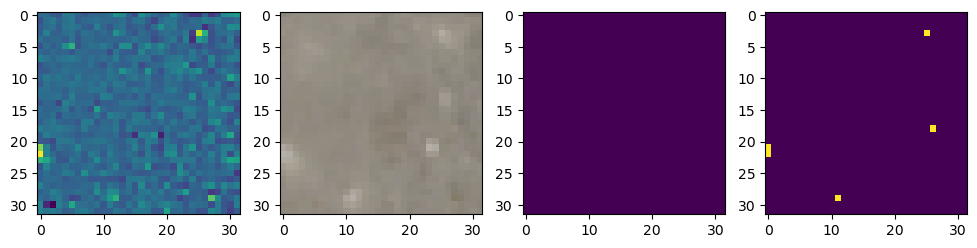

In [24]:
plt.close()
fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=4)
axs[0].imshow(image_dict['tpi'].squeeze(), cmap='viridis')
axs[1].imshow(rgb_out.transpose((1, 2, 0)))
axs[2].imshow(pr_mask, cmap='viridis', clim=(0,1))
axs[3].imshow(label_mask, cmap='viridis', clim=(0,1))
plt.show()

In [16]:
df_downscaled_test = pd.read_csv('./cnn_test_results/downscaled_model_test_validation.csv')
df_best_downscaled_test = pd.read_csv('./cnn_test_results/best_model_downscaled_test_validation.csv')

In [30]:
df_downscaled_test['inputs'].unique()

array(['rgb', 'rgb,ndvi', 'rgb,tpi,shade,dsm', 'rgb,tpi,shade,ndvi',
       'rgb,tpi', 'rgb,tpi,ndvi', 'tpi'], dtype=object)

In [31]:
df_downscaled_test_sub = df_downscaled_test[df_downscaled_test['inputs'].isin(['rgb',
                                                                               'tpi',
                                                                               'rgb,tpi', 
                                                                               'rgb,tpi,ndvi', 
                                                                               'rgb,tpi,shade,ndvi'])]

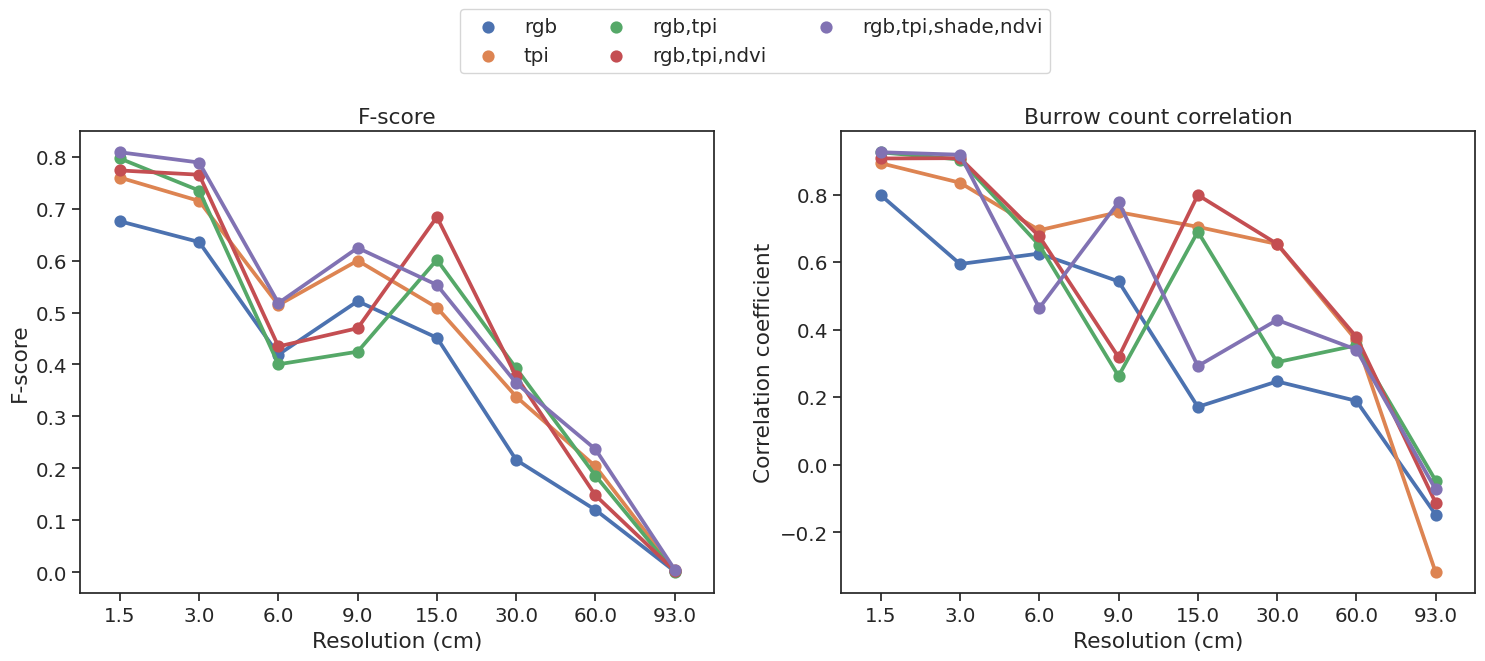

In [32]:
sns.set(font_scale = 1.3)
sns.set_style("ticks")
fig, axs = plt.subplots(figsize=(18, 6), ncols=2)
sns.pointplot(x='test_resolution', y='fscore', 
            hue='inputs', hue_order=['rgb', 'tpi', 'rgb,tpi', 'rgb,tpi,ndvi', 'rgb,tpi,shade,ndvi'],
            data=df_downscaled_test_sub.sort_values('model_resolution'),
            ci=None,
            ax=axs[0], show_legend=False)
#sns.pointplot(x='test_resolution', y='fscore', 
#            hue='inputs',
#            data=df_best_downscaled_test.sort_values('test_resolution'),
#            ci=None,
#            ax=axs[0], show_legend=False,
#            linestyles='dotted')
axs[0].set_title('F-score')
axs[0].set_ylabel('F-score')

sns.pointplot(x='test_resolution', y='correlation', 
            hue='inputs', hue_order=['rgb', 'tpi', 'rgb,tpi', 'rgb,tpi,ndvi', 'rgb,tpi,shade,ndvi'],
            data=df_downscaled_test_sub.sort_values('test_resolution'),
            ci=None,
            ax=axs[1], show_legend=False)
#sns.pointplot(x='test_resolution', y='correlation', 
#            hue='inputs',
#            data=df_best_downscaled_test.sort_values('test_resolution'),
#            ci=None,
#            ax=axs[1], show_legend=False,
#            linestyles='dotted')
axs[1].set_title('Burrow count correlation')
axs[1].set_ylabel('Correlation coefficient')
for ax in axs:
    ax.set_xlabel('Resolution (cm)')
    ax.legend().remove()
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0, 0, 1.0, 1.1), ncol=3)
plt.savefig('./results_figs/cnn_results_downscaled_test_validation.png',
            dpi=400, bbox_inches='tight', pad_inches=0.1)

In [46]:
test_idx = 1
row = df_val[(df_val['inputs'] == 'rgb,tpi,shade,ndvi') & (df_val['resolution'] == 15.0)].iloc[0]

preprocess = True
print(row[['scaling', 'resolution', 'inputs']])
res = row['resolution']
scaling = row['scaling']
inputs_fnl = row['inputs'].split(',')
# load best saved checkpoint
best_model = torch.load(row['model_path'])
best_model.eval()

newsize = int(round((3000 / res) / 32, 0)) * 32
if newsize > 256:
    newsize = int((3000 / res) / 256) * 256

# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats' + scaling + '.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in [x for x in inputs_fnl if x != 'dsm']}

precision_list = []
recall_list = []

burrow_ct_gt = []
burrow_ct_pred = []
tile_id_list = []

ID = df_tiles['ID'][(df_tiles['Train'] == 0) &
                         (df_tiles['Digitize'] == 1) &
                         (df_tiles['trainer'] != 'Nick')].iloc[test_idx]
print(ID)
# get the path base to the imagery associated with the training tile
if external_path is None:
    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
else:
    tilePATH = os.path.join(external_path,
                            df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0])
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
tile_geom = Polygon([ll, ul, ur, lr])
# create the full path to the RGB image of the training tile
rgb_path = tilePATH + 'rgb.tif'
with rio.open(rgb_path) as src_rgb:   
    profile_rgb = src_rgb.meta
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    #rgb_out = rgb_out[:, -win_size:, :win_size]
    #show(rgb_out)
    ll_i = src_rgb.index(*ll)
    ur_i = src_rgb.index(*ur)
    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
    if len(gdf_polys_sub) > 0:
        label_mask = rasterize(gdf_polys_sub.geometry, 
                               out_shape=rgb_out.shape[1:], 
                               transform=transform_out,
                               default_value=1)
    else:
         label_mask = np.zeros_like(rgb_out[0, :, :]) 
    rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                     (newsize, newsize),
                     order=1).transpose((2, 0, 1)).astype('int')
    label_mask = resize(label_mask.astype('float32'), (newsize, newsize), anti_aliasing=True, order=1) > 0.5
    label_mask = label_mask.astype('int')
    #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
    profile_rgb.update({'dtype': 'int16',
                        'width': rgb_out.shape[0],
                        'height': rgb_out.shape[1],
                        'transform': transform_out})
    profile_single = profile_rgb.copy()
    profile_single.update({'count': 1})
    profile_single_float = profile_single.copy()
    profile_single_float.update({'dtype': 'float64'})
    #show(label)

pr_mask = np.empty_like(rgb_out[0, :, :])
image_dict = {}
for suffix in inputs_fnl:
    with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
        i_out = src_i.read(out_shape=(
            src_i.count,
            src_rgb.meta['height'],
            src_rgb.meta['width']),
                           resampling=Resampling.bilinear)
        image_dict[suffix] = resize(i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1].transpose((1, 2, 0)),
                                    (newsize, newsize),
                                    order=1).transpose((2, 0, 1))
if 'rgb' in inputs_fnl:
    image_dict['rgb'] = rgb_out
if preprocess:
    for i in image_dict:
        image_dict[i] = normalize_fn(image_dict[i], i, image_stats)
image_list = [image_dict[i].astype('float32') for i in inputs_fnl]
image_out = np.concatenate(image_list, axis=0)

chunksize = 256
if newsize > 256:
    pr_mask = np.empty_like(rgb_out[0, :, :])
    n_row_chunks = int(np.ceil(rgb_out.shape[1]/chunksize))
    n_col_chunks = int(np.ceil(rgb_out.shape[2]/chunksize))
    image_sub_dict = {}
    for r in range(n_row_chunks):
        if (r + 1) * chunksize > rgb_out.shape[1]:
            r_min = rgb_out.shape[1] - chunksize
            r_max = rgb_out.shape[1]
        else:
            r_min = r * chunksize
            r_max = (r + 1) * chunksize
        for c in range(n_col_chunks):
            if (c + 1) * chunksize > rgb_out.shape[2]:
                c_min = rgb_out.shape[2] - chunksize
                c_max = rgb_out.shape[2]
            else:
                c_min = c * chunksize
                c_max = (c + 1) * chunksize
            image_out_sub = image_out[:, r_min:r_max, c_min:c_max]
            x_tensor = torch.from_numpy(image_out_sub).to(DEVICE).unsqueeze(0)
            if type(best_model) == nn.DataParallel:
                pr_mask[r_min:r_max, c_min:c_max] = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
            else:
                pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
else:
    x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
    if type(best_model) == nn.DataParallel:
        pr_mask = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
    else:
        pr_mask = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5

# get regions and properties of the ground truth and predictions
label_labels = label(label_mask)
label_regions = regionprops(label_labels)
pr_labels = label(pr_mask)
pr_regions = regionprops(pr_labels)

r_ct_pred = 0
for r in pr_regions:
    if r.area*(res/100)**2 > 0.05:
        y_pr, x_pr = r.centroid
        precision_list.append(label_mask[int(y_pr), int(x_pr)])
        r_ct_pred += 1

r_ct_gt = 0
for r in label_regions:
    y_label, x_label = r.centroid
    recall_list.append(pr_mask[int(y_label), int(x_label)])
    r_ct_gt += 1
burrow_ct_gt.append(r_ct_gt)
burrow_ct_pred.append(r_ct_pred)
tile_id_list.append(ID)

scaling              _downscaled
resolution                  15.0
inputs        rgb,tpi,shade,ndvi
Name: 7, dtype: object
5W_14


In [47]:
precision_list

[1, 1, 0, 1, 1]

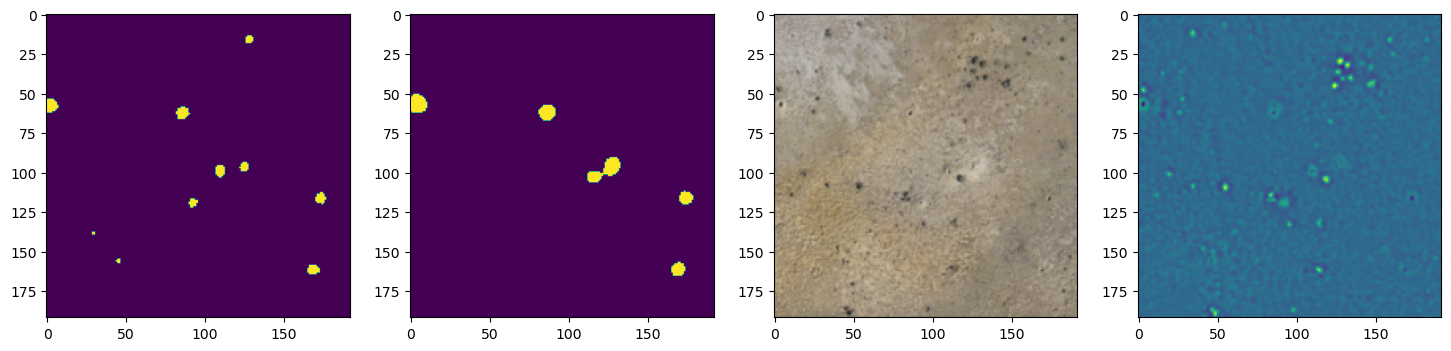

In [40]:
fig, axs = plt.subplots(figsize=(18, 8), ncols=4)
axs[0].imshow(label_mask)
axs[1].imshow(pr_mask)
axs[2].imshow(rgb_out.transpose((1, 2, 0)))
axs[3].imshow(image_dict['tpi'].squeeze())

In [34]:
gdf_polys_sub

,Unnamed: 0,orig_index,Comment,Tile,Trainer,geometry,group,subID
